This notebook has been inspired by the short FREE course offered by  'Career Foundry' (https://careerfoundry.com); in this course the tutor uses google sheets to walk the prospective students through a data analysis mini project. Here I will replicate this 'walk' using pandas. 

What is 'pandas'?
"pandas is a software library written for the Python programming language for data manipulation and analysis. In particular, it offers data structures and operations for manipulating numerical tables and time series..." (source:https://en.wikipedia.org/wiki/Pandas_(software)); 

pandas is a Python library( python library (rough definition): collection of ready made functions ); 

In google sheets the software and the working enverionment,i.e the worksheet are launched together, in order to use pandas functionality pandas has to be imported into your work space; this may feel unfamiliar if coming from a .xls environment,howver it is very simple to import libraries into a notebook:

In [1]:
# hash is used to add quick information about what you are going to do. 
# import libraries 
import pandas as pd # I am telling the system to retrieve the pandas library, and that from now on when I need to use it I will call it pd 
import numpy as np # numpy is another library , conventionally pandas and numpy are imported at the same time, I am keeping with the convention here although I will not need numpy here. 

In [2]:
# import sql data
import sqlite3
from sqlite3 import Error

In [3]:
import pandas as pd
import sqlite3

# return tables in the SQL

con = sqlite3.connect('../input/new-york-city-taxi-trips-2019/2019/2019-01.sqlite')

cursor = con.cursor()

cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")

print(cursor.fetchall())

[('tripdata',)]


In [4]:
# slect only nrows : 'SELECT * FROM .... LIMIT 100'
df = pd.read_sql('SELECT * FROM tripdata LIMIT 20000', con)


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   vendorid               20000 non-null  float64
 1   tpep_pickup_datetime   20000 non-null  object 
 2   tpep_dropoff_datetime  20000 non-null  object 
 3   passenger_count        20000 non-null  float64
 4   trip_distance          20000 non-null  float64
 5   ratecodeid             20000 non-null  float64
 6   store_and_fwd_flag     20000 non-null  object 
 7   pulocationid           20000 non-null  float64
 8   dolocationid           20000 non-null  float64
 9   payment_type           20000 non-null  float64
 10  fare_amount            20000 non-null  float64
 11  extra                  20000 non-null  float64
 12  mta_tax                20000 non-null  float64
 13  tip_amount             20000 non-null  float64
 14  tolls_amount           20000 non-null  float64
 15  im

In [6]:
# Initail clean up drop missing values: first check where the missing values aree

df[df['fare_amount'].isna()] # find all missing values in 'fare_amount'


,vendorid,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,ratecodeid,store_and_fwd_flag,pulocationid,dolocationid,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge


In [ ]:
#if happy drop na, if not opt to fill missing values
df.dropna(inplace=True) 

In [7]:
# collect rows where the fare amount is below zero, for checking before dropping
fare_below_0 = df[df['fare_amount']<0]

In [8]:
# keep  bigger than 0 fare_amount values
df= df[df['fare_amount']>0] 

In [9]:
# report min, max, mean and median
pd.options.display.float_format = "{:,.2f}".format #display only 2 decimal places

key_num = df['fare_amount'].describe().T
key_num['median']= df['fare_amount'].median()
key_num

count    19,972.00
mean         12.92
std          10.82
min           0.01
25%           6.50
50%          10.00
75%          16.00
max         496.50
median       10.00
Name: fare_amount, dtype: float64

In [10]:
#pick uo location frequency
pd.options.display.float_format = "{:,.0f}".format 
frequncy_pick_up_location = ((df['pulocationid'].value_counts())).reset_index().rename(columns={"index": "Frequency"}).sort_values(by='Frequency', ascending=False)

In [132]:
#report 10 most popular pick up locations
frequncy_pick_up_location.head(10)

,Frequency,pulocationid
86,265.00,12
25,264.00,338
8,263.00,605
35,262.00,213
49,261.00,86


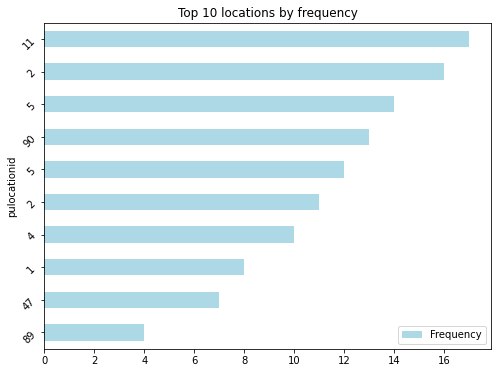

In [133]:
#Visualize : bar chart of 10 most popular pick up loacations
figsize=(30,20)
viz_top_10= (frequncy_pick_up_location.sort_values(by='Frequency', ascending='False')).head(10)

ax = viz_top_10.plot.barh(x='pulocationid', y='Frequency', rot=45, figsize=(8,6), color ='lightblue', title='Top 10 locations by frequency')

In [134]:
# Calculate mean( average) trip distance in relation to number of passangers
pd.options.display.float_format = "{:,.2f}".format
passanger_distance = df.groupby(['passenger_count'])['trip_distance'].agg(['mean']).reset_index()
print(passanger_distance)

   passenger_count  mean
0             0.00  3.10
1             1.00  2.94
2             2.00  2.95
3             3.00  3.00
4             4.00  2.91
5             5.00  3.07
6             6.00  3.01


<AxesSubplot:>

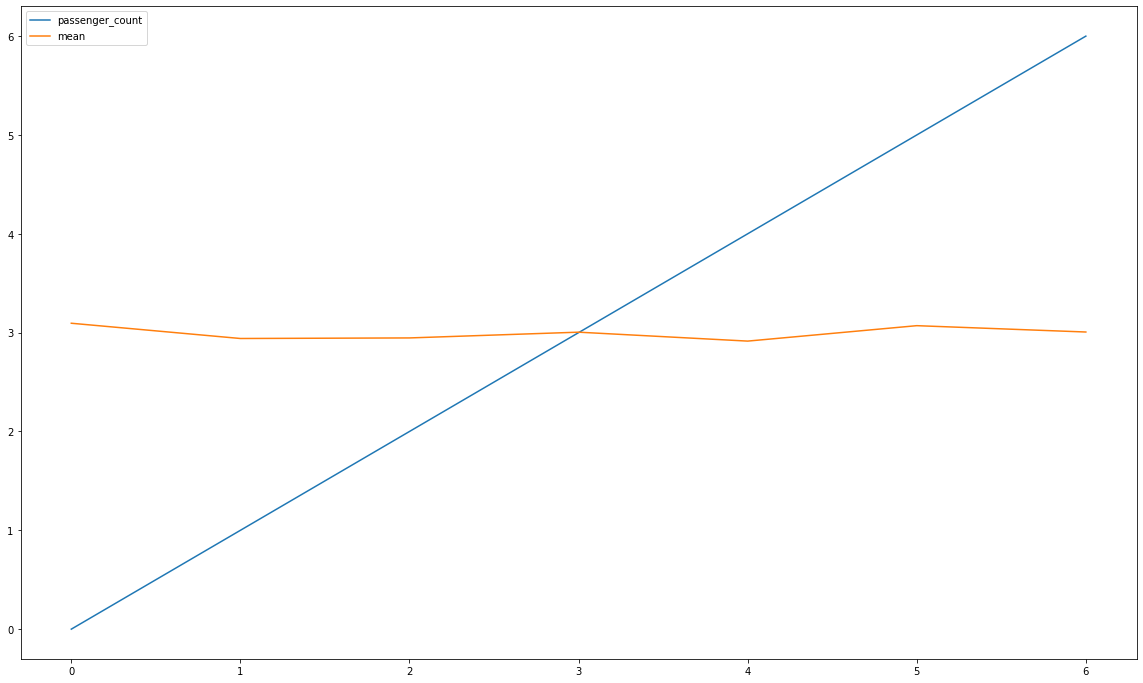

In [135]:
#Visualize number of passangers vs average trip distance
passanger_distance.plot.line(figsize=(20,12))

In [136]:
# Payment types visualizations: most popular payment method
payment1 = (df['payment_type'].value_counts()).to_frame().T
payment1.columns=["Credit card", "Cash","No charge", "Dispute" ]
payment2 = payment1.T
payment2.reset_index(inplace=True)

In [137]:
import plotly.express as px

fig = px.pie(payment2, values=payment2['payment_type'], names=payment2['index'], title='payment_type')
fig.show()

In [127]:
# Payment types visualizations: most popular payment method by vendor
payment_type_by_vendor = (df.groupby(['vendorid', 'payment_type'])['payment_type'].count()).reset_index(name='frequency')
payment_type_by_vendor['payment_type']=payment_type_by_vendor['payment_type'].astype(int)
payment_type_by_vendor['payment_type'] = (payment_type_by_vendor['payment_type']).replace({1: 'Credit card', 2: 'Cash',3: 'No charge',4: 'Dispute'})
pivoted = payment_type_by_vendor.pivot(index="vendorid", columns="payment_type", values="frequency").reset_index()
pivoted

payment_type,vendorid,Cash,Credit card,Dispute,No charge
0,1.00,"2,448.00","4,758.00",41.00,104.00
1,2.00,"4,345.00","8,035.00",NaN,NaN
2,4.00,93.00,148.00,NaN,NaN


Text(0, 0.5, 'vendorid')

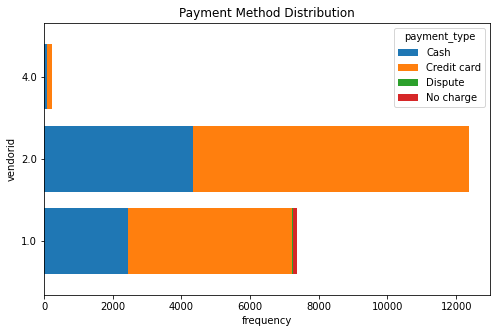

In [138]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8,5))  
pivoted[['Cash','Credit card','Dispute','No charge']].plot.barh(rot=0, width=.8,ax = ax,stacked=True)

ax.set_yticklabels(pivoted['vendorid'])
plt.xlabel('frequency')
plt.title('Payment Method Distribution')
plt.ylabel('vendorid')
